In [1]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from train_finn import main

In [2]:
train_data_dir = Path("../data_out/finn_stds_input").resolve()
model, t_train, c_train = main(
    y_train_path=train_data_dir / f"Y_neg_finn_quantile=90.npy",
    output_dir=Path("../data_out/finn_stds_ouput/Y_neg_finn_quantile=90").resolve(),
    train_split_idx=51,
)

Saving files to /Users/r/Documents/stud/ss24/finnpinn/data_out/finn_neg
Loading data from /Users/r/Documents/stud/ss24/finnpinn/data_out/finn_PI_datasets/Y_neg_finn.npy
Training: Epoch [2/100], Training Loss: 3.9292, Runtime: 18.2895 secs
Training: Epoch [3/100], Training Loss: 1.4408, Runtime: 15.6201 secs
Training: Epoch [4/100], Training Loss: 0.0769, Runtime: 13.8337 secs
Training: Epoch [5/100], Training Loss: 0.0430, Runtime: 12.7165 secs
Training: Epoch [6/100], Training Loss: 0.0425, Runtime: 12.9422 secs
Training: Epoch [7/100], Training Loss: 0.0425, Runtime: 12.6988 secs
Training: Epoch [8/100], Training Loss: 0.0422, Runtime: 12.8486 secs
Training: Epoch [9/100], Training Loss: 0.0222, Runtime: 12.5906 secs
Training: Epoch [10/100], Training Loss: 0.0088, Runtime: 14.0849 secs
Training: Epoch [11/100], Training Loss: 0.0083, Runtime: 13.7725 secs
Training: Epoch [12/100], Training Loss: 0.0082, Runtime: 14.0736 secs
Training: Epoch [13/100], Training Loss: 0.0081, Runtime: 

# Analyze Results

In [3]:
model.eval()
with torch.no_grad():
    c_predictions = model(t_train)
c_predictions = c_predictions.detach().cpu().numpy()
residuals = c_predictions - c_train.numpy()

In [4]:
print(np.abs(residuals).max())

0.0025890893


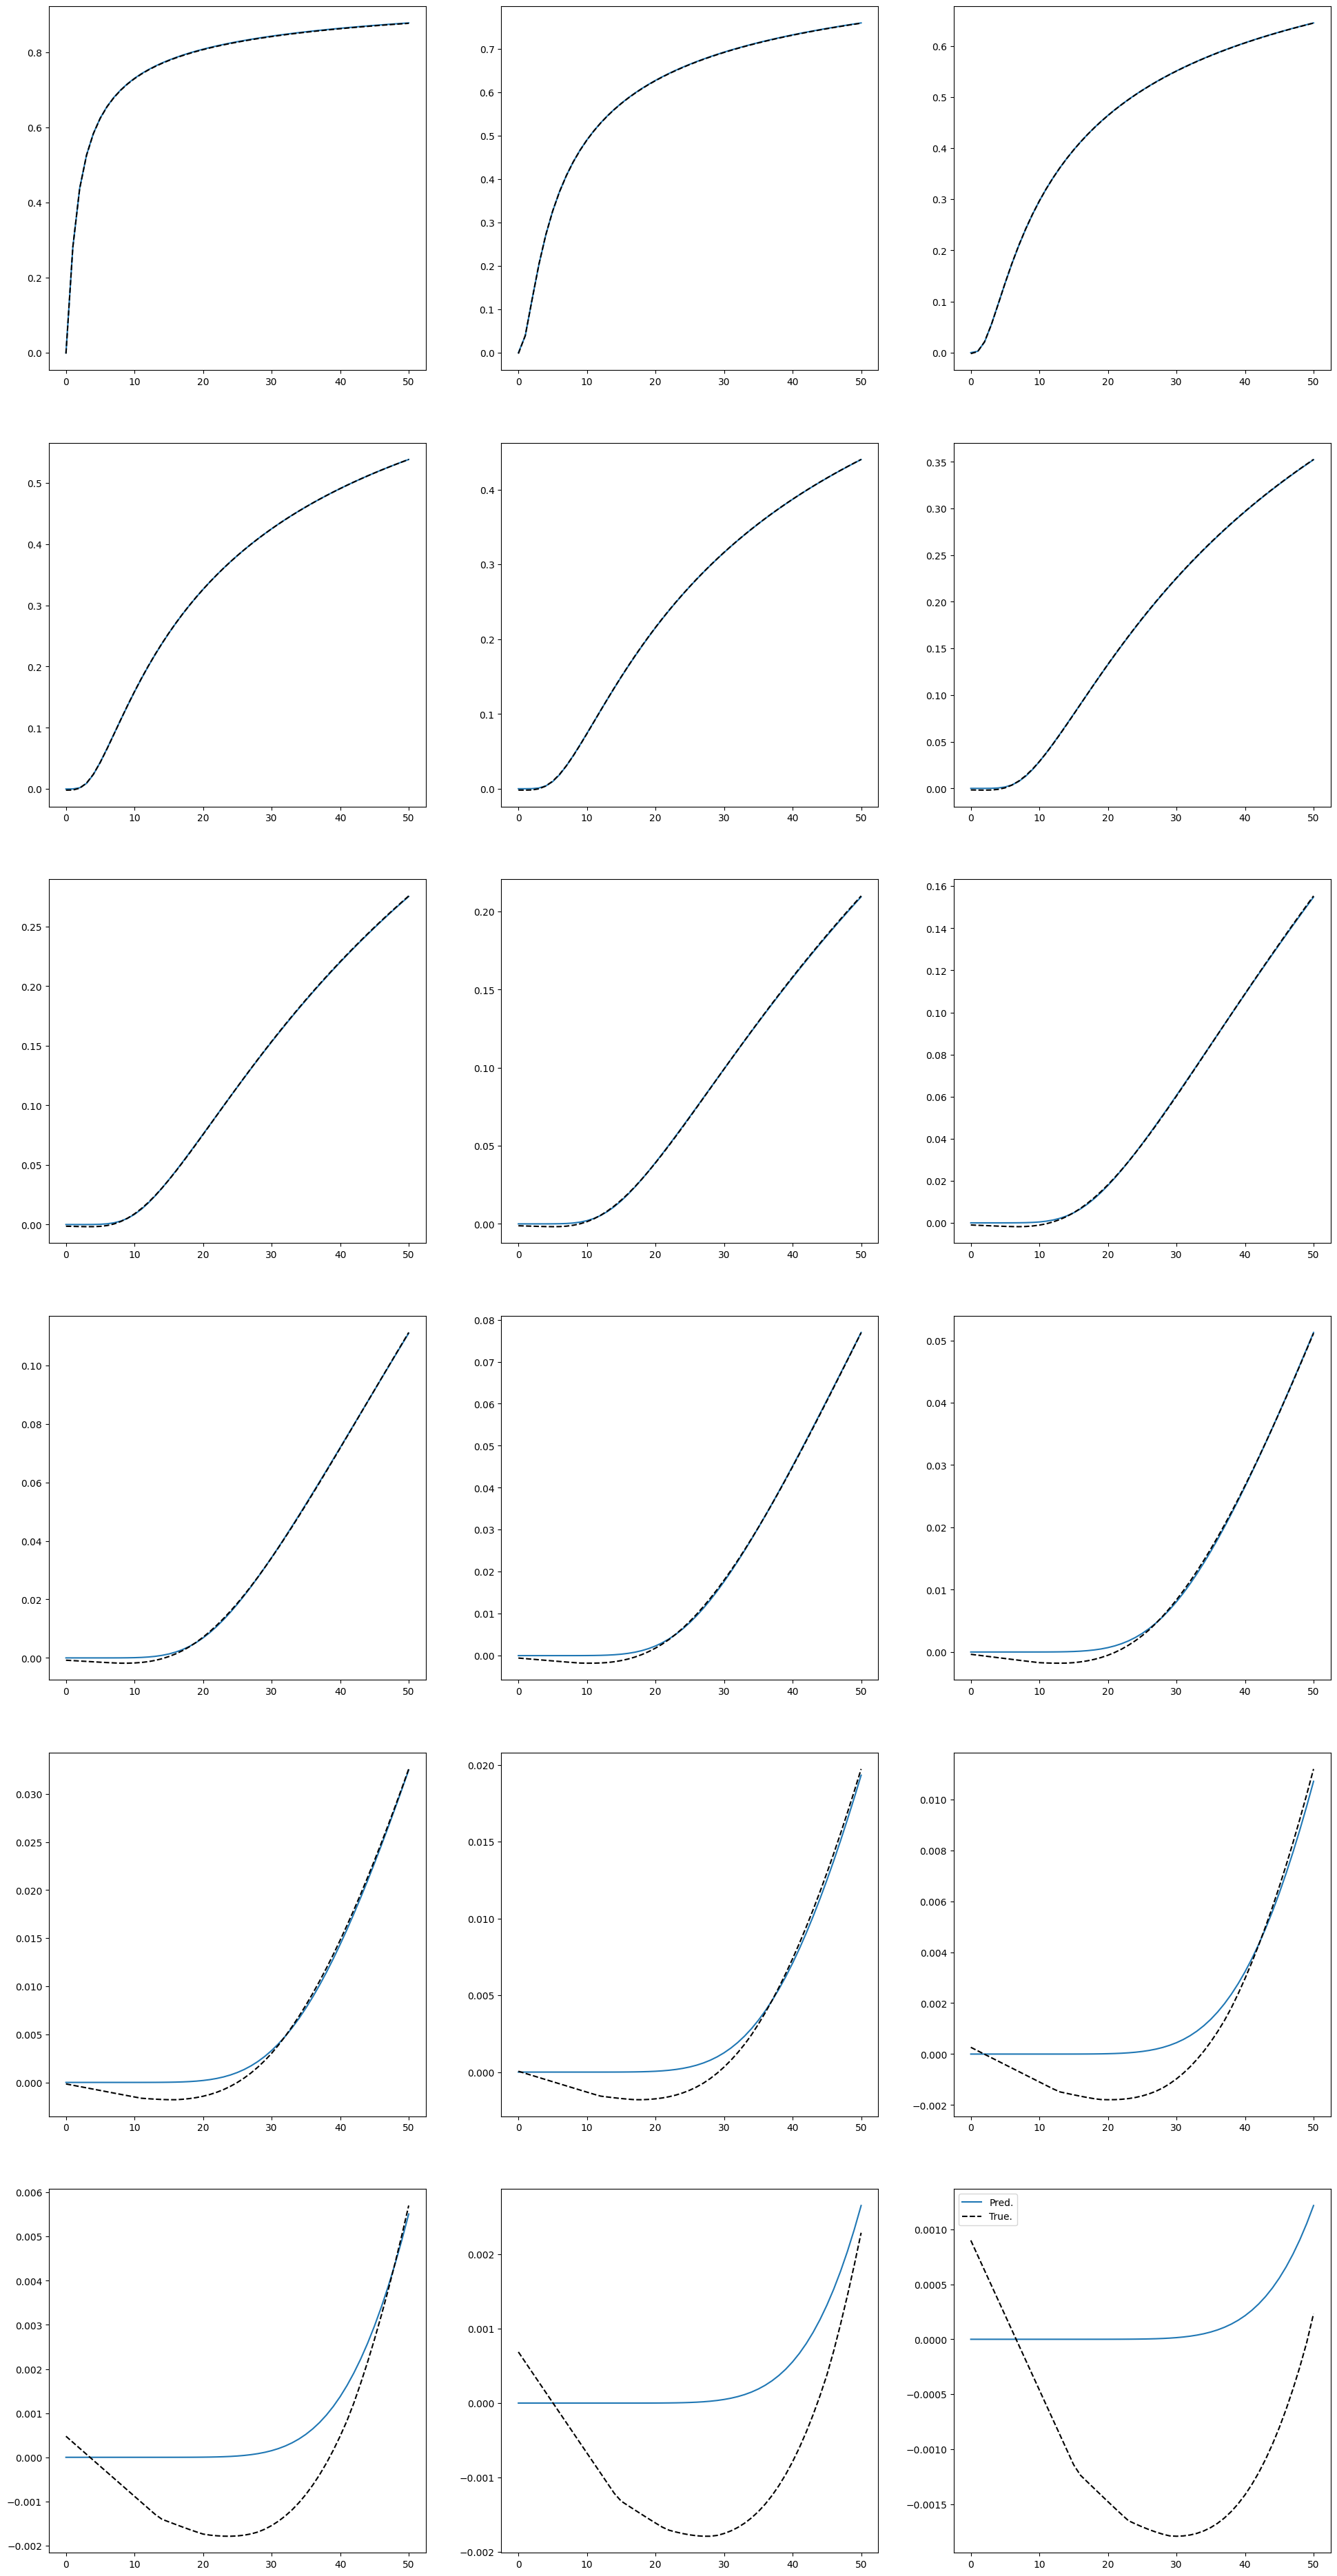

In [5]:
from math import ceil
ncols = 3
nrows = ceil(26/5)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8*ncols,8*nrows))
axs = axs.flatten()
for i, ax in zip(range(c_train.shape[2]), axs):
    ax.plot(c_predictions[:, 0, i, 0], label="Pred.")
    ax.plot(c_train[:, 0, i, 0], "k--", label="True.")
plt.legend()
plt.show()

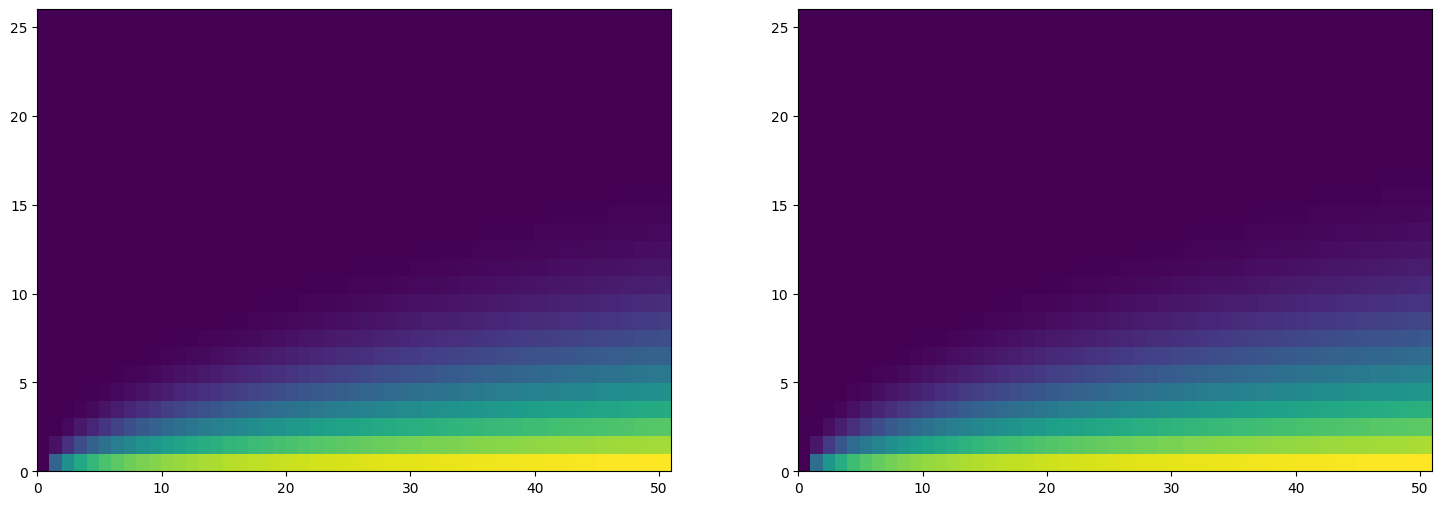

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.pcolor(c_predictions[:, 0, :, 0].T)
ax2.pcolor(c_predictions[:, 1, :, 0].T)
plt.show()

# Analyze predictions

In [7]:
from common import plot_c, plot_c_timeseries, plot_c_spaceseries

In [8]:
print(c_predictions.shape)

(51, 2, 26, 1)


# Retardation

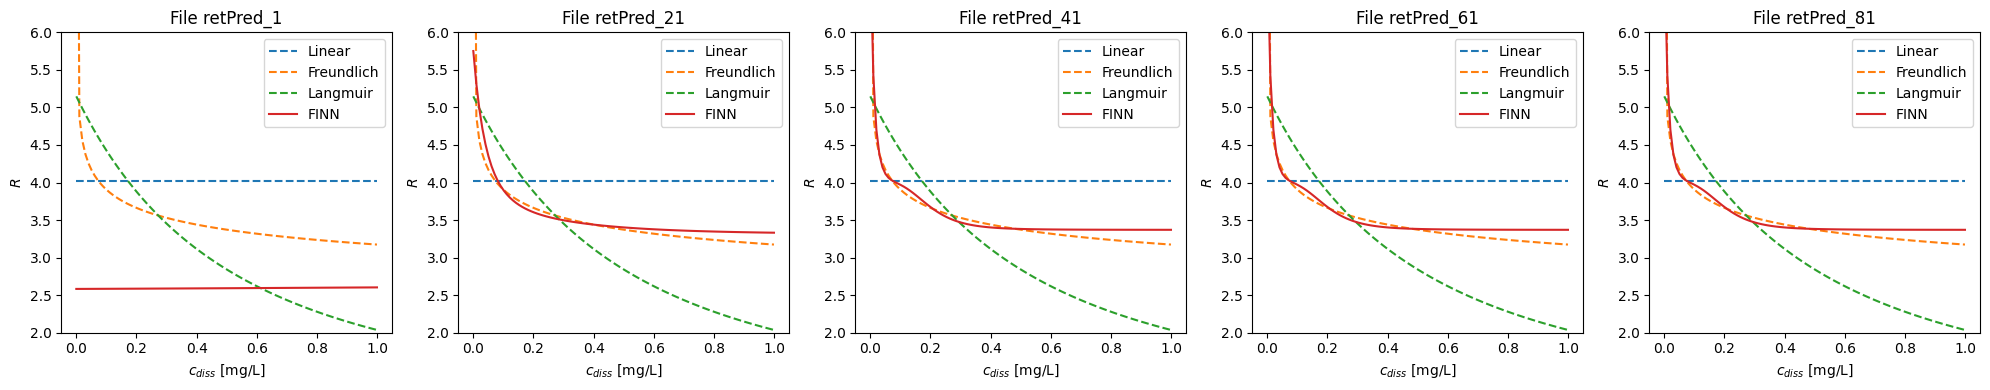

In [9]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


def plot_retardation():
    base_dir = Path("../data_out/finn_neg").resolve()

    # Load retardation data for different models
    u = np.load(base_dir / "u_ret.npy")
    retardation_linear = np.load(base_dir / "retardation_linear.npy")
    retardation_freundlich = np.load(base_dir / "retardation_freundlich.npy")
    retardation_langmuir = np.load(base_dir / "retardation_langmuir.npy")

    fig, ax = plt.subplots()
    ax.set_ylim([2, 6])
    plt.plot(u, retardation_linear, linestyle="--", label="Linear")
    plt.plot(u, retardation_freundlich, linestyle="--", label="Freundlich")
    plt.plot(u, retardation_langmuir, linestyle="--", label="Langmuir")

    (ret_pred,) = ax.plot(u, np.zeros_like(u), label="FINN")

    plt.title("Predicted Retardation Factor", fontsize=16)
    plt.xlabel(r"$c_{diss}$ [mg/L]", fontsize=16)
    plt.ylabel(r"$R$", fontsize=16)
    plt.legend(fontsize=16)
    plt.tight_layout()

    pred_ret_path = base_dir / "predicted_retardations"

    def update(file_path):
        ret_pred_data = np.load(file_path)
        ret_pred.set_ydata(ret_pred_data)
        ax.set_ylim([2, 6])
        ax.set_title(f"Predicted Retardation Factor ({file_path.stem})")

    all_files = sorted(
        (p.absolute() for p in pred_ret_path.glob("retPred_*.npy")),
        key=lambda p: int(p.stem.split("_")[-1]),
    )
    files = all_files[:: max(1, len(all_files) // 5)]

    ani = animation.FuncAnimation(fig, update, frames=all_files[::3], interval=200)

    # Save the animation as gif
    ani.save("../retardation_animation.gif", writer="imagemagick")

    # Display the animation in the notebook
    plt.close(fig)
    display(HTML(ani.to_jshtml()))

    # Display static images for the 5 epochs
    fig, axes = plt.subplots(1, len(files), figsize=(4 * len(files), 4))
    for ax, file in zip(axes, files):
        ret_pred_data = np.load(file)
        ax.plot(u, retardation_linear, linestyle="--", label="Linear")
        ax.plot(u, retardation_freundlich, linestyle="--", label="Freundlich")
        ax.plot(u, retardation_langmuir, linestyle="--", label="Langmuir")
        ax.plot(u, ret_pred_data, label="FINN")
        ax.set_title(f"File {file.stem}")
        ax.set_xlabel(r"$c_{diss}$ [mg/L]")
        ax.set_ylabel(r"$R$")
        ax.set_ylim([2, 6])
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_retardation()

In [10]:
import params
x = np.linspace(0.0, params.X, params.Nx)

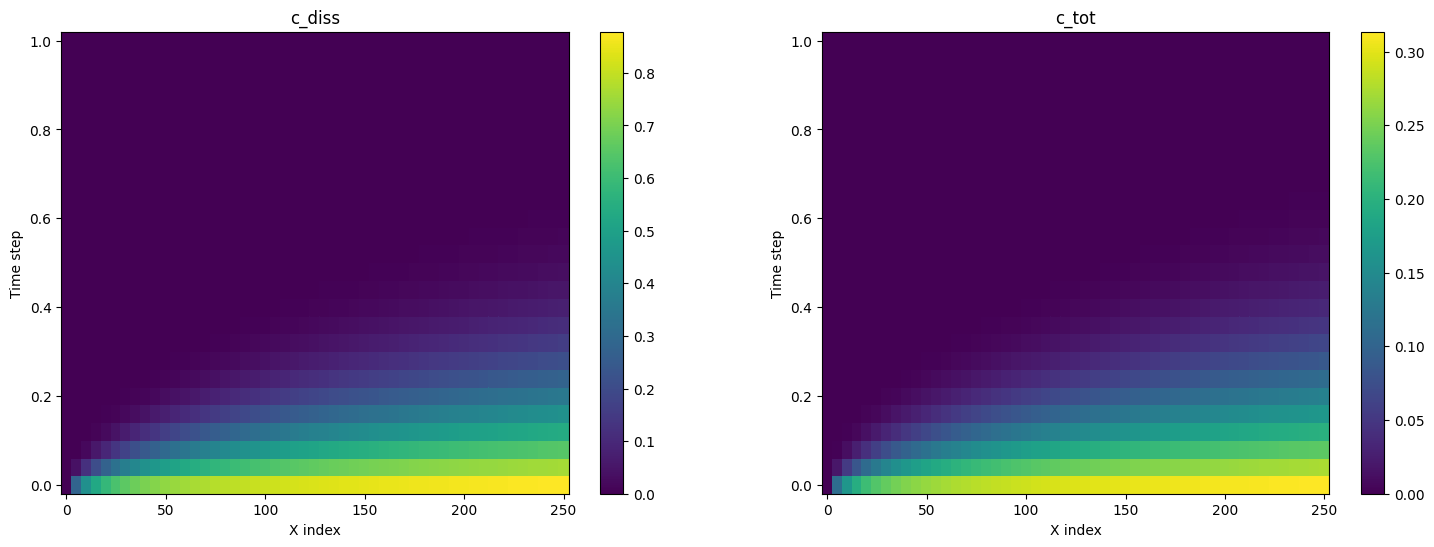

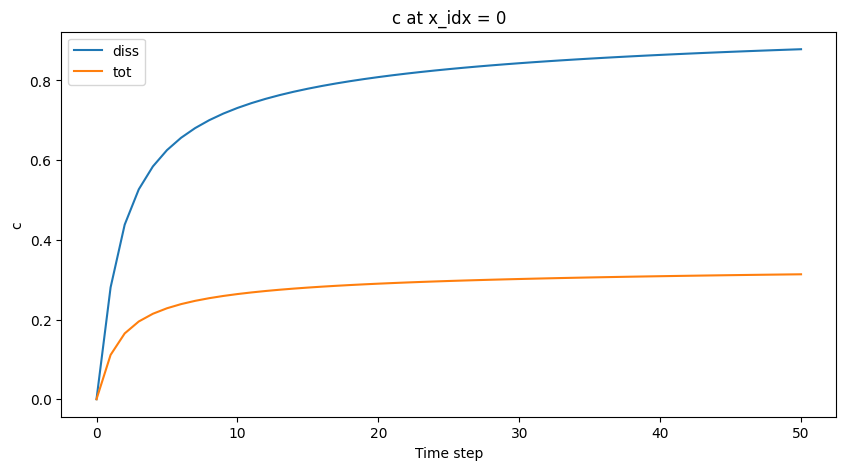

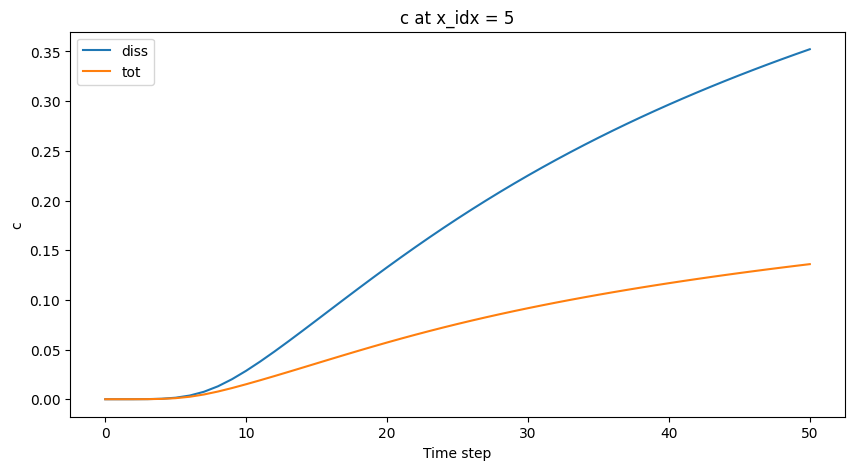

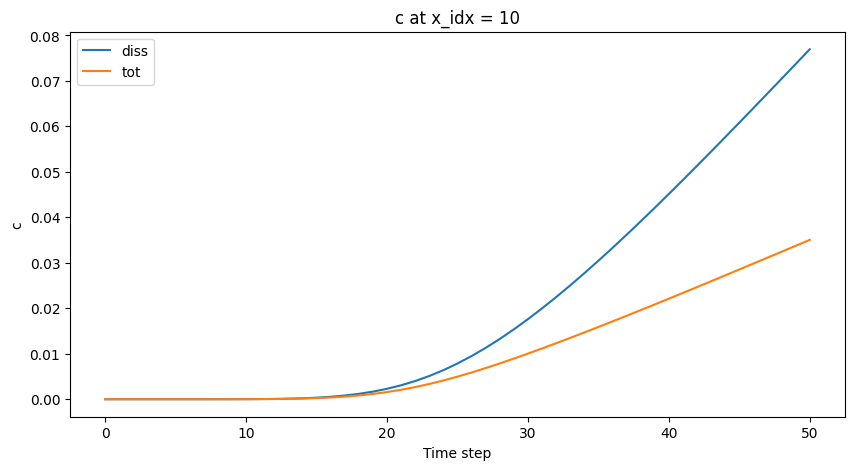

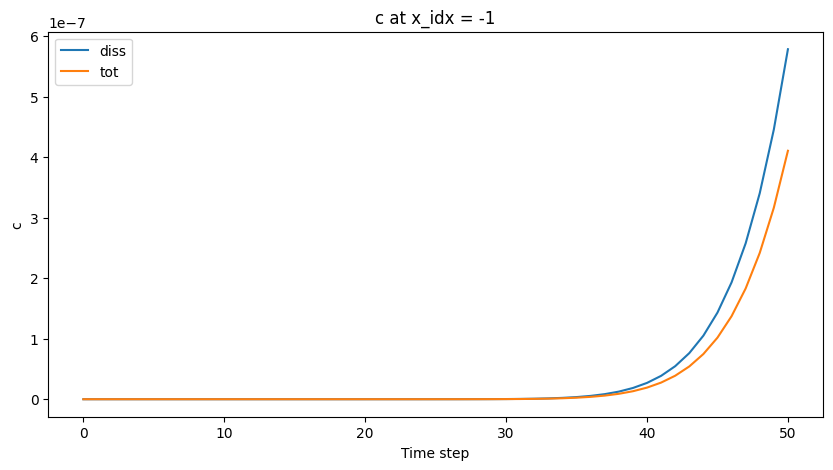

In [11]:
X, T = np.meshgrid(x, t_train)
plot_c(t=T, x=X, c=c_predictions[...,0])
plot_c_timeseries(c_predictions[...,0], x_idx=0)
plot_c_timeseries(c_predictions[...,0], x_idx=5)
plot_c_timeseries(c_predictions[...,0], x_idx=10)
plot_c_timeseries(c_predictions[...,0], x_idx=-1)
plt.show()

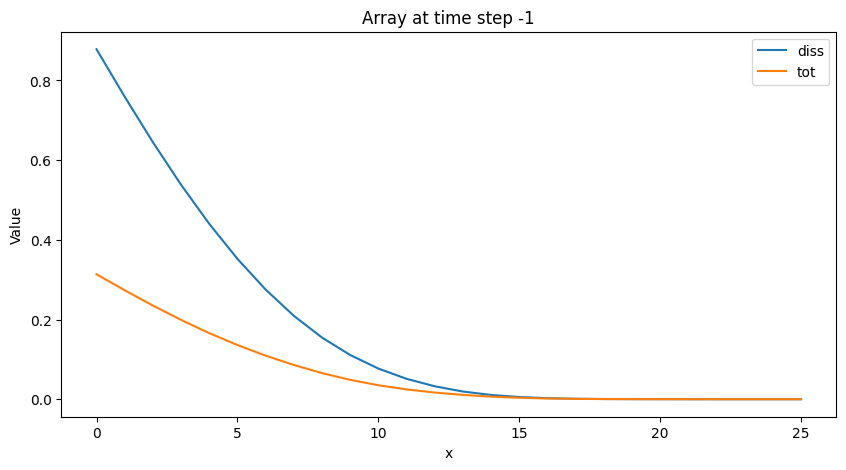

In [12]:
plot_c_spaceseries(c_predictions[...,0], t_idx=-1)

# Training Data

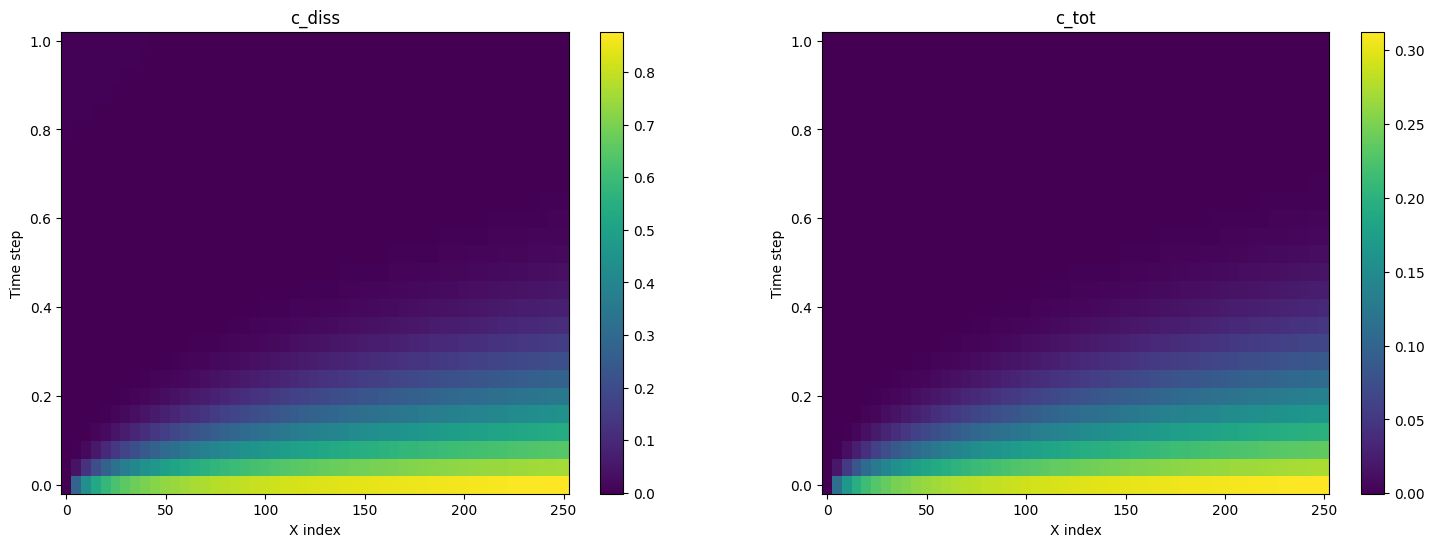

In [13]:
plot_c(t=T, x=X, c=c_train[...,0])